In [2]:
!pip install sentence-transformers scikit-learn matplotlib seaborn nltk rouge-score sacrebleu

In [4]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from rouge_score import rouge_scorer
import sacrebleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
df = pd.read_csv(r'd:\s\ai-project\data\labeled_resume_job_dataset.csv')
print(df.head())
print(df['Match_Label'].value_counts())

                                         Resume_Text  \
0  Skills: Pediatric Care, Neonatal Resuscitation...   
1  Skills: Special Education, IEP Development, Be...   
2  Skills: Bridge Design, AutoCAD Civil 3D, Struc...   
3  Skills: Pharmacology, Clinical Trials, FDA Com...   
4  Skills: Curriculum Design, STEM Education, Rob...   

                                     Job_Description  Match_Label  
0  Seeking pediatric nurse with NICU experience a...            1  
1  Special education teacher needed with autism s...            1  
2  Civil engineer position requiring bridge desig...            1  
3  Clinical research coordinator needed with onco...            1  
4  Physics teacher required with robotics club le...            1  
Match_Label
0    432
1    386
Name: count, dtype: int64


In [8]:
X = df[['Resume_Text', 'Job_Description']]
y = df['Match_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 654, Test size: 164


In [10]:
# Load a pre-trained SBERT model
model = SentenceTransformer('all-mpnet-base-v2')

def compute_similarity(resumes, jobs):
    resume_emb = model.encode(resumes, convert_to_tensor=True)
    job_emb = model.encode(jobs, convert_to_tensor=True)
    # Cosine similarity
    sim = (resume_emb * job_emb).sum(dim=1) / (resume_emb.norm(dim=1) * job_emb.norm(dim=1))
    return sim.cpu().numpy()

# Compute similarities for train and test
train_sim = compute_similarity(X_train['Resume_Text'].tolist(), X_train['Job_Description'].tolist())
test_sim = compute_similarity(X_test['Resume_Text'].tolist(), X_test['Job_Description'].tolist())

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, train_sim)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.652


In [14]:
y_pred = (test_sim >= optimal_threshold).astype(int)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, test_sim)
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.957, F1: 0.954, ROC-AUC: 0.986
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        87
           1       0.96      0.95      0.95        77

    accuracy                           0.96       164
   macro avg       0.96      0.96      0.96       164
weighted avg       0.96      0.96      0.96       164



In [36]:
# Extract features for train and test sets
train_features = np.array([extract_features(resume, job) for resume, job in zip(X_train['Resume_Text'], X_train['Job_Description'])])
test_features = np.array([extract_features(resume, job) for resume, job in zip(X_test['Resume_Text'], X_test['Job_Description'])])

In [44]:
# Combine similarity and contextual features
import sklearn.linear_model as sk
train_X = np.hstack([train_sim.reshape(-1, 1), train_features])
test_X = np.hstack([test_sim.reshape(-1, 1), test_features])

# Train a logistic regression classifier
clf = sk.LogisticRegression(class_weight='balanced', random_state=42)  # Balanced weights for better recall
clf.fit(train_X, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [46]:
# Predict and evaluate
y_pred = clf.predict(test_X)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(test_X)[:, 1])
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.945, F1: 0.942, ROC-AUC: 0.989
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        87
           1       0.94      0.95      0.94        77

    accuracy                           0.95       164
   macro avg       0.94      0.95      0.94       164
weighted avg       0.95      0.95      0.95       164



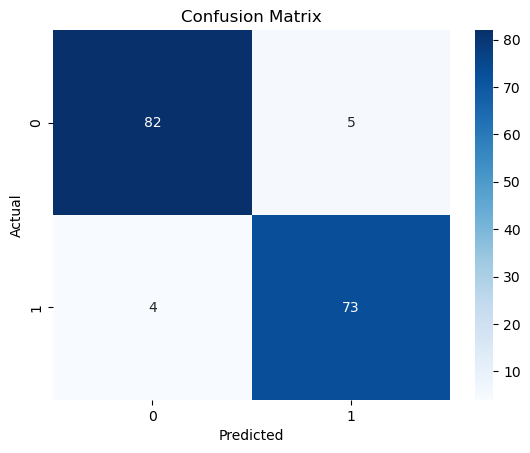

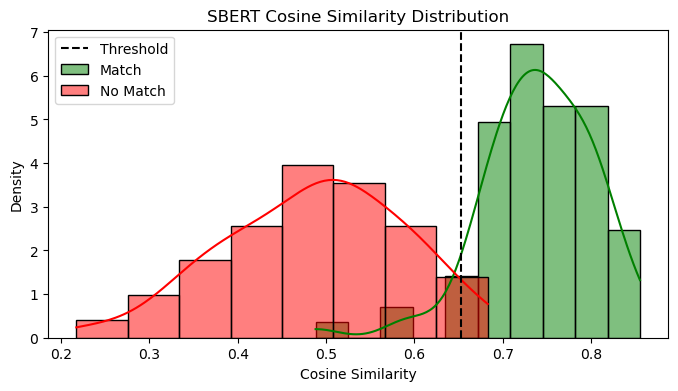

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Distribution of Similarity Scores
plt.figure(figsize=(8,4))
sns.histplot(test_sim[y_test==1], color='g', label='Match', kde=True, stat='density')
sns.histplot(test_sim[y_test==0], color='r', label='No Match', kde=True, stat='density')
plt.axvline(optimal_threshold, color='k', linestyle='--', label='Threshold')
plt.legend()
plt.title('SBERT Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.show()

In [50]:
# BLEU (using sacrebleu)
bleu = sacrebleu.corpus_bleu(X_test['Resume_Text'].tolist(), [X_test['Job_Description'].tolist()])
print(f"Corpus BLEU: {bleu.score:.2f}")

# ROUGE (using rouge-score)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougel = [], [], []
for ref, hyp in zip(X_test['Job_Description'], X_test['Resume_Text']):
    scores = scorer.score(ref, hyp)
    rouge1.append(scores['rouge1'].fmeasure)
    rouge2.append(scores['rouge2'].fmeasure)
    rougel.append(scores['rougeL'].fmeasure)
print(f"ROUGE-1: {np.mean(rouge1):.3f}, ROUGE-2: {np.mean(rouge2):.3f}, ROUGE-L: {np.mean(rougel):.3f}")

Corpus BLEU: 0.88
ROUGE-1: 0.192, ROUGE-2: 0.052, ROUGE-L: 0.146


In [52]:
for i in range(6):
    print(f"Resume: {X_test.iloc[i]['Resume_Text']}")
    print(f"Job: {X_test.iloc[i]['Job_Description']}")
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}, Similarity: {test_sim[i]:.3f}\n")

Resume: Skills: Social Work, Case Management, Crisis Intervention, Community Resources. Experience: Licensed Clinical Social Worker (LCSW) at Community Support Services. Projects: Homeless Outreach Program, Mental Health Support Group Facilitation.
Job: LCSW needed for case management role, experience with crisis intervention preferred.
Actual: 1, Predicted: 1, Similarity: 0.699

Resume: Skills: Training Specialist, Curriculum Development, Learning Management Systems (LMS), Needs Analysis, Training Evaluation. Experience: Training Coordinator at SkillBuilders Corp. Projects: Developed E-Learning Modules for New Hires, Conducted Training Needs Analysis.
Job: Training Specialist wanted with experience designing and delivering employee training.
Actual: 1, Predicted: 1, Similarity: 0.707

Resume: Skills: Paralegal (Corporate), Entity Formation, Corporate Governance, Contract Review, Due Diligence. Experience: Corporate Paralegal at Global Law Firm LLP. Projects: Managed Entity Formations 